In [1]:
%run utils.ipynb

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [4]:
df=pd.read_csv("../data/train.csv")
df_copy=df.copy()

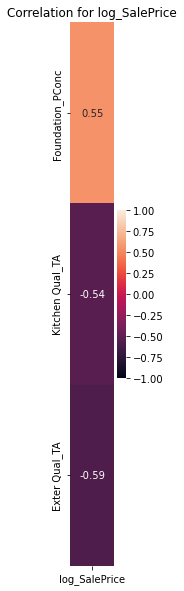

In [5]:
#change SalePrice to log_SalePrice
df=log_and_return(df_copy.copy(),"SalePrice",drop=True)

#one hot encode only categorical features
df_new=onehot_encode_categorical_features(df,return_number=False,label="log_SalePrice")

# display(df_new.dtypes)
#look at correlation to log_saleprice
single_correlation_map(df_new,"log_SalePrice")

Okay, so we'll add these 3 features to our list of features from part 3.

In [6]:
features_to_keep=['Overall Cond',
 'Kitchen AbvGr',
 'Fireplaces',
 'Bsmt Full Bath',
 'Full Bath',
 'TotRms AbvGrd',
 'Garage Cars',
 'Land Slope',
 'Overall Qual',
 'Central Air',
 'Yr Sold',
 'Kitchen Qual',
    'Foundation_PConc','Kitchen Qual_TA','Exter Qual_TA']

In [7]:
cols_to_impute_with_none=["Pool QC","Misc Feature","Alley","Fence","Fireplace Qu",
                          "Garage Finish","Garage Qual","Garage Cond","Garage Type",
                         "Bsmt Exposure","BsmtFin Type 2","Bsmt Cond","Bsmt Qual","BsmtFin Type 1",
                         "Mas Vnr Type"]

cols_to_impute_with_zero=["Garage Yr Blt","Mas Vnr Area","Bsmt Full Bath","Bsmt Half Bath","Garage Area",
                         "Garage Cars","Total Bsmt SF","Bsmt Unf SF","BsmtFin SF 2","BsmtFin SF 1"]

cols_to_impute_with_mode=["Electrical"]

In [8]:
#Create a regressor to dynamically creates a pipeline
def create_regressor(model,**kwargs):
    '''
    model: estimator instance
    return: TransformedTargetRegressor
    '''
    pipeline=Pipeline(steps=[
        ('standard_impute',StandardImpute(none=cols_to_impute_with_none,
                                          zero=cols_to_impute_with_zero,
                                          mode=cols_to_impute_with_mode)),
        ('lot_frotage_impute',LotFrontageImpute()),
        ('ordinal_to_numerical',OrdinalToNumeric()),
        ('onehotencode',OneHotEncode()),
        ('align_train_and_predict',AlignTrainPredict(**kwargs)), #This is to align the train and predict DF in case they are different
        ('passthrough',Passthrough()), #Passthrough step, does nothing. Only exists to allow external code to retrieve feature names.
        ('model',model)
    ])
    
    return TransformedTargetRegressor(regressor=pipeline,
                                    func=np.log1p,
                                    inverse_func=np.expm1
                                    )

In [9]:
df=df_copy.copy()

#set up X and Y
X=df.drop(columns="SalePrice")
y=df["SalePrice"]

#make a backup copy
X_copy=X.copy()
y_copy=y.copy()

In [10]:
RMSE=[]
coefficients=[]
feature_names=None

#create regressor and instruct to keep only numerical features
lr=create_regressor(LinearRegression(),feature_names=features_to_keep)

#run 10 K Folds and store the coefficients and RMSE to a list.
kf=KFold(n_splits=5,random_state=30,shuffle=True)
for train_index, test_index in tqdm(kf.split(X_copy.copy())):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lr.fit(X_train,y_train)
    ypred=lr.predict(X_test)
    RMSE.append(mean_squared_error(y_test,ypred,squared=False))
    coefficients.append(lr.regressor_['model'].coef_)
    feature_names=list(lr.regressor_['passthrough'].get_feature_names())

0it [00:00, ?it/s]

In [11]:
np.mean(RMSE)

33346.79710390261

### Try a submission

In [12]:
#Instantiate a copy of Tester helper class
tester=Tester("../data/test.csv")

In [13]:
lr.fit(X, y)#obtain a copy of the test set
df_test=tester.get_test_df()

In [14]:
#reset the df
X=X_copy.copy()

#instantiate and train the model using the entire dataset
lr=create_regressor(LinearRegression(),feature_names=features_to_keep)
lr.fit(X,y)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('standard_impute',
                                                      StandardImpute(mode=['Electrical'],
                                                                     none=['Pool '
                                                                           'QC',
                                                                           'Misc '
                                                                           'Feature',
                                                                           'Alley',
                                                                           'Fence',
                                                                           'Fireplace '
                                                                           'Qu',
                                                                           'Garage '
                                                                           'Finish',
                                                                           'Garage '
                                                                           'Qual',
                                                                           'Garage '
                                                                           'Cond',
                                                                           'Garage '
                                                                           'Type',
                                                                           'Bsmt '
                                                                           'Exposure',
                                                                           'BsmtFin '
                                                                           'Type '
                                                                           '2',
                                                                           'Bsmt '
                                                                           'Cond',
                                                                           'Bsmt '
                                                                           'Qual',
                                                                           'BsmtF...
                                                     ('align_train_and_predict',
                                                      AlignTrainPredict(feature_names=['Overall '
                                                                                       'Cond',
                                                                                       'Kitchen '
                                                                                       'AbvGr',
                                                                                       'Fireplaces',
                                                                                       'Bsmt '
                                                                                       'Full '
                                                                                       'Bath',
                                                                                       'Full '
                                                                                       'Bath',
                                                                                       'TotRms '
                                                                                       'AbvGrd',
                                                                                       'Garage '
                                                                                       'Cars',
                                                                                       'Land '
                                                     

In [15]:
#make prediction
ypred=lr.predict(df_test)

In [16]:
tester.write_submission(ypred,"../data/04_categorical_features.csv")

Output saved to ../data/04_categorical_features.csv
